<a href="https://colab.research.google.com/github/pankaj18/GAN_specialization_coursera/blob/main/C3W2_SRGAN_(Optional).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super-resolution GAN (SRGAN)

*Please note that this is an optional notebook meant to introduce more advanced concepts. If you’re up for a challenge, take a look and don’t worry if you can’t follow everything. There is no code to implement—only some cool code for you to learn and run!*

It is recommended that you should already be familiar with:
 - Residual blocks, from [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) (He et al. 2015)
 - Perceptual loss, from [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155) (Johnson et al. 2016)
 - VGG architecture, from [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556) (Simonyan et al. 2015)

### Goals

In this notebook, you will learn about Super-Resolution GAN (SRGAN), a GAN that enhances the resolution of images by 4x, proposed in [Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802) (Ledig et al. 2017). You will also implement the architecture and training in full and be able to train it on the CIFAR dataset.

### Background

The authors first train a super-resolution residual network (SRResNet) with standard pixel-wise loss that achieves state-of-the-art metrics. They then insert this as the generator in the SRGAN framework, which is trained with a combination of pixel-wise, perceptual, and adversarial losses.

## SRGAN Submodules

Before jumping into SRGAN, let's first take a look at some components that will be useful later.

### Parametric ReLU (PReLU)

As you already know, ReLU is one of the simplest activation functions that can be described as

\begin{align*}
    x_{\text{ReLU}} := \max(0, x),
\end{align*}

where negative values of $x$ become thresholded at $0$. However, this stops gradient through these negative values, which can hinder training. The authors of [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852) addressed this by introducing a more general ReLU by scaling negative values by some constant $a > 0$:

\begin{align*}
    x_{\text{PReLU}} := \max(0, x) + a * \min(0, x).
\end{align*}

Conveniently, this is implemented in Pytorch as [torch.nn.PReLU](https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html)

### Residual Blocks

The residual block, which is relevant in many state-of-the-art computer vision models, is used in all parts of SRGAN and is similar to the ones used in Pix2PixHD (see optional notebook). If you're not familiar with residual blocks, please take a look [here](https://paperswithcode.com/method/residual-block). Now, you'll start by first implementing a basic residual block.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    '''
    ResidualBlock Class
    Values
        channels: the number of channels throughout the residual block, a scalar
    '''

    def __init__(self, channels):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),

            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
        )

    def forward(self, x):
        return x + self.layers(x)

###  PixelShuffle

Proposed in [Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/abs/1609.05158) (Shi et al. 2016), PixelShuffle, also called sub-pixel convolution, is another way to upsample an image.

PixelShuffle simply reshapes a $r^2C\ x\ H\ x\ W$ tensor into a $C\ x\ rH\ x\ rW$ tensor, essentially trading channel information for spatial information. Instead of convolving with stride $1/r$ as in deconvolution, the authors think about the weights in the kernel as being spaced $1/r$ pixels apart. When sliding this kernel over an input, the weights that fall between pixels aren't activated and don't need need to be calculated. The total number of activation patterns is thus increased by a factor of $r^2$. This operation is illustrated in the figure below.

Don't worry if this is confusing! The algorithm is conveniently implemented as `torch.nn.PixelShuffle` in PyTorch, so as long as you have a general idea of how this works, you're set.

> ![Efficient Sub-pixel CNN](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/SRGAN-PixelShuffle.png?raw=true)
*Efficient sub-pixel CNN, taken from Figure 1 of [Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/abs/1609.05158) (Shi et al. 2016). The PixelShuffle operation (also known as sub-pixel convolution) is shown as the last step on the right.*

## SRGAN Parts

Now that you've learned about the various SRGAN submodules, you can now use them to build the generator and discriminator!

### Generator (SRResNet)

The super-resolution residual network (SRResNet) and the generator are the same thing. The generator network architecture is actually quite simple - just a bunch of convolutional layers, residual blocks, and pixel shuffling layers!

> ![SRGAN Generator](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/SRGAN-Generator.png?raw=true)
*SRGAN Generator, taken from Figure 4 of [Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802) (Ledig et al. 2017).*

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        base_channels: number of channels throughout the generator, a scalar
        n_ps_blocks: number of PixelShuffle blocks, a scalar
        n_res_blocks: number of residual blocks, a scalar
    '''

    def __init__(self, base_channels=64, n_ps_blocks=2, n_res_blocks=16):
        super().__init__()
        # Input layer
        self.in_layer = nn.Sequential(
            nn.Conv2d(3, base_channels, kernel_size=9, padding=4),
            nn.PReLU(),
        )

        # Residual blocks
        res_blocks = []
        for _ in range(n_res_blocks):
            res_blocks += [ResidualBlock(base_channels)]

        res_blocks += [
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels),
        ]
        self.res_blocks = nn.Sequential(*res_blocks)

        # PixelShuffle blocks
        ps_blocks = []
        for _ in range(n_ps_blocks):
            ps_blocks += [
                nn.Conv2d(base_channels, 4 * base_channels, kernel_size=3, padding=1),
                nn.PixelShuffle(2),
                nn.PReLU(),
            ]
        self.ps_blocks = nn.Sequential(*ps_blocks)

        # Output layer
        self.out_layer = nn.Sequential(
            nn.Conv2d(base_channels, 3, kernel_size=9, padding=4),
            nn.Tanh(),
        )

    def forward(self, x):
        x_res = self.in_layer(x)
        x = x_res + self.res_blocks(x_res)
        x = self.ps_blocks(x)
        x = self.out_layer(x)
        return x

### Discriminator

The discriminator architecture is also relatively straightforward, just one big sequential model - see the diagram below for reference!

![SRGAN Generator](https://github.com/https-deeplearning-ai/GANs-Public/blob/master/SRGAN-Discriminator.png?raw=true)
*SRGAN Discriminator, taken from Figure 4 of [Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/abs/1609.04802) (Ledig et al. 2017).*

In [3]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        base_channels: number of channels in first convolutional layer, a scalar
        n_blocks: number of convolutional blocks, a scalar
    '''

    def __init__(self, base_channels=64, n_blocks=3):
        super().__init__()
        self.blocks = [
            nn.Conv2d(3, base_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(base_channels),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        cur_channels = base_channels
        for i in range(n_blocks):
            self.blocks += [
                nn.Conv2d(cur_channels, 2 * cur_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(2 * cur_channels),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(2 * cur_channels, 2 * cur_channels, kernel_size=3, padding=1, stride=2),
                nn.BatchNorm2d(2 * cur_channels),
                nn.LeakyReLU(0.2, inplace=True),
            ]
            cur_channels *= 2

        self.blocks += [
            # You can replicate nn.Linear with pointwise nn.Conv2d
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(cur_channels, 2 * cur_channels, kernel_size=1, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(2 * cur_channels, 1, kernel_size=1, padding=0),

            # Apply sigmoid if necessary in loss function for stability
            nn.Flatten(),
        ]

        self.layers = nn.Sequential(*self.blocks)

    def forward(self, x):
        return self.layers(x)

## Loss Functions

The authors formulate the perceptual loss as a weighted sum of content loss (based on the VGG19 network) and adversarial loss.

\begin{align*}
    \mathcal{L} &= \mathcal{L}_{VGG} + 10^{-3}\mathcal{L}_{ADV}
\end{align*}

**Content Loss**

Previous approaches have used MSE loss for content loss, but this objective function tends to produce blurry images. To address this, they add an extra MSE loss term on VGG19 feature maps. So for feature map $\phi_{5,4}$ (the feature map after the 4th convolution before the 5th max-pooling layer) from the VGG19 network,

\begin{align*}
    \mathcal{L}_{VGG} &= \left|\left|\phi_{5,4}(I^{\text{HR}}) - \phi_{5,4}(G(I^{\text{LR}}))\right|\right|_2^2
\end{align*}

where $I^{\text{HR}}$ is the original high-resolution image and $I^{\text{LR}}$ is the corresponding low-resolution image.

**Adversarial Loss**

You should already be familiar with adversarial loss, which is formulated as

\begin{align*}
    \mathcal{L}_{ADV} &= \sum_{n=1}^N -\log D(G(I^{\text{LR}}))
\end{align*}

Note that $-\log D(G(\cdot))$ is used instead of $\log [1 - D(G(\cdot))]$ for better gradient behavior.

In [4]:
from torchvision.models import vgg19

class Loss(nn.Module):
    '''
    Loss Class
    Implements composite content+adversarial loss for SRGAN
    Values:
        device: 'cuda' or 'cpu' hardware to put VGG network on, a string
    '''

    def __init__(self, device='cuda'):
        super().__init__()

        vgg = vgg19(pretrained=True).to(device)
        self.vgg = nn.Sequential(*list(vgg.features)[:-1]).eval()
        for p in self.vgg.parameters():
            p.requires_grad = False

    @staticmethod
    def img_loss(x_real, x_fake):
        return F.mse_loss(x_real, x_fake)

    def adv_loss(self, x, is_real):
        target = torch.zeros_like(x) if is_real else torch.ones_like(x)
        return F.binary_cross_entropy_with_logits(x, target)

    def vgg_loss(self, x_real, x_fake):
        return F.mse_loss(self.vgg(x_real), self.vgg(x_fake))

    def forward(self, generator, discriminator, hr_real, lr_real):
        ''' Performs forward pass and returns total losses for G and D '''
        hr_fake = generator(lr_real)
        fake_preds_for_g = discriminator(hr_fake)
        fake_preds_for_d = discriminator(hr_fake.detach())
        real_preds_for_d = discriminator(hr_real.detach())

        g_loss = (
            0.001 * self.adv_loss(fake_preds_for_g, False) + \
            0.006 * self.vgg_loss(hr_real, hr_fake) + \
            self.img_loss(hr_real, hr_fake)
        )
        d_loss = 0.5 * (
            self.adv_loss(real_preds_for_d, True) + \
            self.adv_loss(fake_preds_for_d, False)
        )

        return g_loss, d_loss, hr_fake

## Training SRGAN

Now it's time to train your SRGAN! Let's first begin by defining our dataset

In [5]:
from PIL import Image
import numpy as np
import torchvision
import torchvision.transforms as transforms

# We are using STL (for speed and also since ImageNet is no longer publicly available)
USING_STL = True
if USING_STL:
    DatasetSubclass = torchvision.datasets.STL10
else:
    DatasetSubclass = torchvision.datasets.ImageNet

class Dataset(DatasetSubclass):
    '''
    Dataset Class
    Implements a general dataset class for STL10 and ImageNet
    Values:
        hr_size: spatial size of high-resolution image, a list/tuple
        lr_size: spatial size of low-resolution image, a list/tuple
        *args/**kwargs: all other arguments for subclassed torchvision dataset
    '''

    def __init__(self, *args, **kwargs):
        hr_size = kwargs.pop('hr_size', [96, 96])
        lr_size = kwargs.pop('lr_size', [24, 24])
        super().__init__(*args, **kwargs)

        if hr_size is not None and lr_size is not None:
            assert hr_size[0] == 4 * lr_size[0]
            assert hr_size[1] == 4 * lr_size[1]

        # High-res images are cropped and scaled to [-1, 1]
        self.hr_transforms = transforms.Compose([
            transforms.RandomCrop(hr_size),
            transforms.RandomHorizontalFlip(),
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        # Low-res images are downsampled with bicubic kernel and scaled to [0, 1]
        self.lr_transforms = transforms.Compose([
            transforms.Normalize((-1.0, -1.0, -1.0), (2.0, 2.0, 2.0)),
            transforms.ToPILImage(),
            transforms.Resize(lr_size, interpolation=Image.BICUBIC),
            transforms.ToTensor(),
        ])

        self.to_pil = transforms.ToPILImage()
        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, idx):
        # Uncomment the following lines if you're using ImageNet
        # path, label = self.imgs[idx]
        # image = Image.open(path).convert('RGB')

        # Uncomment the following if you're using STL
        image = torch.from_numpy(self.data[idx])
        image = self.to_pil(image)

        hr = self.hr_transforms(image)
        lr = self.lr_transforms(hr)
        return hr, lr

    @staticmethod
    def collate_fn(batch):
        hrs, lrs = [], []

        for hr, lr in batch:
            hrs.append(hr)
            lrs.append(lr)

        return torch.stack(hrs, dim=0), torch.stack(lrs, dim=0)

Recall that the generator (SRResNet) is first trained alone with MSE loss and is combined with the discriminator and trained as SRGAN after. Check out the training loops below:

In [6]:
from tqdm import tqdm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Parse torch version for autocast
# ######################################################
version = torch.__version__
version = tuple(int(n) for n in version.split('.')[:-1])
has_autocast = version >= (1, 6)
# ######################################################

def show_tensor_images(image_tensor):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:4], nrow=4)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def train_srresnet(srresnet, dataloader, device, lr=1e-4, total_steps=1e6, display_step=500):
    srresnet = srresnet.to(device).train()
    optimizer = torch.optim.Adam(srresnet.parameters(), lr=lr)

    cur_step = 0
    mean_loss = 0.0
    while cur_step < total_steps:
        for hr_real, lr_real in tqdm(dataloader, position=0):
            hr_real = hr_real.to(device)
            lr_real = lr_real.to(device)

            # Enable autocast to FP16 tensors (new feature since torch==1.6.0)
            # If you're running older versions of torch, comment this out
            # and use NVIDIA apex for mixed/half precision training
            if has_autocast:
                with torch.cuda.amp.autocast(enabled=(device=='cuda')):
                    hr_fake = srresnet(lr_real)
                    loss = Loss.img_loss(hr_real, hr_fake)
            else:
                hr_fake = srresnet(lr_real)
                loss = Loss.img_loss(hr_real, hr_fake)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            mean_loss += loss.item() / display_step

            if cur_step % display_step == 0 and cur_step > 0:
                print('Step {}: SRResNet loss: {:.5f}'.format(cur_step, mean_loss))
                show_tensor_images(lr_real * 2 - 1)
                show_tensor_images(hr_fake.to(hr_real.dtype))
                show_tensor_images(hr_real)
                mean_loss = 0.0

            cur_step += 1
            if cur_step == total_steps:
                break

def train_srgan(generator, discriminator, dataloader, device, lr=1e-4, total_steps=2e5, display_step=500):
    generator = generator.to(device).train()
    discriminator = discriminator.to(device).train()
    loss_fn = Loss(device=device)

    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
    g_scheduler = torch.optim.lr_scheduler.LambdaLR(g_optimizer, lambda _: 0.1)
    d_scheduler = torch.optim.lr_scheduler.LambdaLR(d_optimizer, lambda _: 0.1)

    lr_step = total_steps // 2
    cur_step = 0

    mean_g_loss = 0.0
    mean_d_loss = 0.0

    while cur_step < total_steps:
        for hr_real, lr_real in tqdm(dataloader, position=0):
            hr_real = hr_real.to(device)
            lr_real = lr_real.to(device)

            # Enable autocast to FP16 tensors (new feature since torch==1.6.0)
            # If you're running older versions of torch, comment this out
            # and use NVIDIA apex for mixed/half precision training
            if has_autocast:
                with torch.cuda.amp.autocast(enabled=(device=='cuda')):
                    g_loss, d_loss, hr_fake = loss_fn(
                        generator, discriminator, hr_real, lr_real,
                    )
            else:
                g_loss, d_loss, hr_fake = loss_fn(
                    generator, discriminator, hr_real, lr_real,
                )

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            mean_g_loss += g_loss.item() / display_step
            mean_d_loss += d_loss.item() / display_step

            if cur_step == lr_step:
                g_scheduler.step()
                d_scheduler.step()
                print('Decayed learning rate by 10x.')

            if cur_step % display_step == 0 and cur_step > 0:
                print('Step {}: Generator loss: {:.5f}, Discriminator loss: {:.5f}'.format(cur_step, mean_g_loss, mean_d_loss))
                show_tensor_images(lr_real * 2 - 1)
                show_tensor_images(hr_fake.to(hr_real.dtype))
                show_tensor_images(hr_real)
                mean_g_loss = 0.0
                mean_d_loss = 0.0

            cur_step += 1
            if cur_step == total_steps:
                break

Now initialize everything and run training!


Extracting data/stl10_binary.tar.gz to data


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
 19%|█▉        | 60/313 [00:03<00:15, 16.58it/s]

Step 1000: SRResNet loss: 0.04058


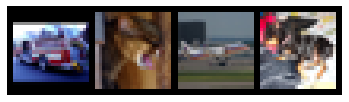

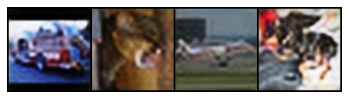

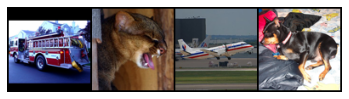

 39%|███▉      | 122/313 [00:07<00:11, 16.43it/s]

Step 2000: SRResNet loss: 0.02779


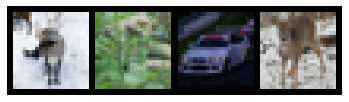

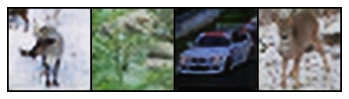

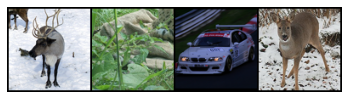

 58%|█████▊    | 182/313 [00:11<00:08, 16.11it/s]

Step 3000: SRResNet loss: 0.02593


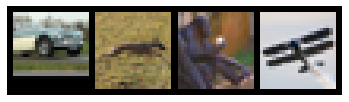

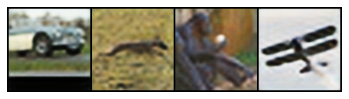

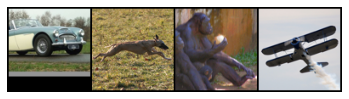

 78%|███████▊  | 244/313 [00:15<00:04, 16.19it/s]

Step 4000: SRResNet loss: 0.02480


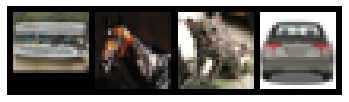

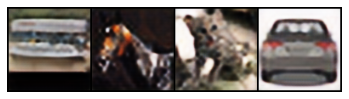

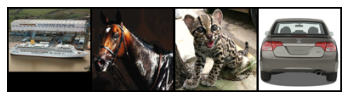

 97%|█████████▋| 304/313 [00:19<00:00, 15.69it/s]

Step 5000: SRResNet loss: 0.02410


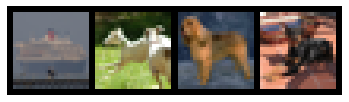

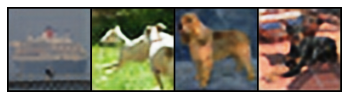

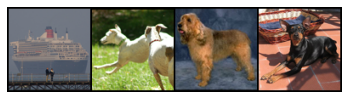

 17%|█▋        | 52/313 [00:03<00:16, 15.78it/s]

Step 6000: SRResNet loss: 0.02341


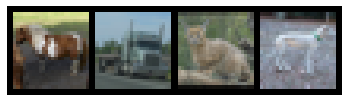

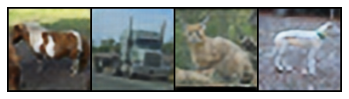

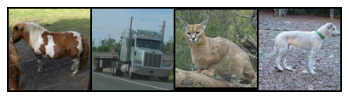

 47%|████▋     | 146/313 [00:09<00:10, 15.65it/s]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = Generator(n_res_blocks=16, n_ps_blocks=2)

# Uncomment the following lines if you're using ImageNet
# dataloader = torch.utils.data.DataLoader(
#     Dataset('data', 'train', download=True, hr_size=[384, 384], lr_size=[96, 96]),
#     batch_size=16, pin_memory=True, shuffle=True,
# )
# train_srresnet(generator, dataloader, device, lr=1e-4, total_steps=1e6, display_step=500)
# torch.save(generator, 'srresnet.pt')

# Uncomment the following lines if you're using STL
dataloader = torch.utils.data.DataLoader(
    Dataset('data', 'train', download=True, hr_size=[96, 96], lr_size=[24, 24]),
    batch_size=16, pin_memory=True, shuffle=True,
)
train_srresnet(generator, dataloader, device, lr=1e-4, total_steps=1e5, display_step=1000)
torch.save(generator, 'srresnet.pt')

In [ ]:
generator = torch.load('srresnet.pt')
discriminator = Discriminator(n_blocks=1, base_channels=8)

# Uncomment the following lines if you're using ImageNet
# train_srgan(generator, discriminator, dataloader, device, lr=1e-4, total_steps=2e5, display_step=500)
# torch.save(generator, 'srgenerator.pt')
# torch.save(discriminator, 'srdiscriminator.pt')

# Uncomment the following lines if you're using STL
train_srgan(generator, discriminator, dataloader, device, lr=1e-4, total_steps=2e5, display_step=1000)
torch.save(generator, 'srgenerator.pt')
torch.save(discriminator, 'srdiscriminator.pt')